In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed,
                                     MultiHeadAttention, LayerNormalization, Add, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping

import os

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10
FORECAST_STEPS = 10
TEST_RATIO = 0.3

# Tuning parameters
EPOCHS_LIST = [10, 20]
BATCH_SIZES = [64, 128]

WINDOW_SIZE_SIMULATION = 10
THRESHOLD_PERCENTILE = 95

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
file_path = '../../csv/dataset_reduced-10min-one-target-variable-TI0036.csv'
df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

# Clean
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

# Add Static Features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Shift'] = ((df['Hour'] >= 6) & (df['Hour'] < 18)).astype(int)

static_features = ['Shift', 'DayOfWeek']
dynamic_features = df.drop(columns=static_features).columns.tolist()

# Scale Dynamic Features Only
scaler = MinMaxScaler()
scaled_dynamic = scaler.fit_transform(df[dynamic_features])
df_scaled = pd.DataFrame(scaled_dynamic, index=df.index, columns=dynamic_features)

# Add Static Features (not scaled)
df_scaled[static_features] = df[static_features]

print(f"✅ Scaled dataset shape: {df_scaled.shape}")

# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================
split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

print(f"✅ Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

# ========================
# 5. CREATE TFT SEQUENCES
# ========================
def create_tft_sequences(data, static_cols, input_steps, forecast_steps):
    X_seq, y_seq, X_static = [], [], []
    for i in range(len(data) - input_steps - forecast_steps):
        input_slice = data.iloc[i:i+input_steps]
        future_slice = data.iloc[i+input_steps:i+input_steps+forecast_steps]
        X_seq.append(input_slice[dynamic_features].values)
        y_seq.append(future_slice[dynamic_features].values)
        X_static.append(input_slice[static_cols].iloc[-1].values)
    return np.array(X_seq), np.array(y_seq), np.array(X_static)

X_train_seq, y_train_seq, X_train_static = create_tft_sequences(train_data, static_features, INPUT_STEPS, FORECAST_STEPS)
X_test_seq, y_test_seq, X_test_static = create_tft_sequences(test_data, static_features, INPUT_STEPS, FORECAST_STEPS)

print(f"✅ Training sequences: {X_train_seq.shape}, Testing sequences: {X_test_seq.shape}")

# ========================
# 6. BUILD TFT MODEL
# ========================
def build_full_tft_model(input_steps, forecast_steps, input_dim, static_dim, embed_dim=64, num_heads=4):
    seq_input = Input(shape=(input_steps, input_dim), name="seq_input")
    static_input = Input(shape=(static_dim,), name="static_input")

    static_dense = Dense(embed_dim, activation='relu')(static_input)
    static_context = RepeatVector(input_steps)(static_dense)

    merged_input = Concatenate()([seq_input, static_context])
    x_proj = Dense(embed_dim)(merged_input)
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x_proj, x_proj)
    x = Add()([x_proj, attn_out])
    x = LayerNormalization()(x)

    encoded = LSTM(embed_dim)(x)
    repeated = RepeatVector(forecast_steps)(encoded)
    decoded = LSTM(embed_dim, return_sequences=True)(repeated)

    output = TimeDistributed(Dense(input_dim))(decoded)

    model = Model(inputs=[seq_input, static_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# ========================
# 7. TRAINING + TUNING
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training TFT with epochs={epochs}, batch_size={batch_size}")
        
        model = build_full_tft_model(INPUT_STEPS, FORECAST_STEPS, len(dynamic_features), len(static_features))
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit([X_train_seq, X_train_static], y_train_seq,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)
        
        val_preds = model.predict([X_test_seq, X_test_static], batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1)))
        val_mae = mean_absolute_error(y_test_seq.reshape(-1), val_preds.reshape(-1))

        print(f"✅ Validation RMSE: {val_rmse:.5f}, MAE: {val_mae:.5f}")

        history_records.append({
            "epochs": epochs,
            "batch_size": batch_size,
            "val_rmse": val_rmse,
            "val_mae": val_mae
        })

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model

# Save tuning history
history_df = pd.DataFrame(history_records)
history_df.to_csv("tft_tuning_history.csv", index=False)
print("\n📋 Tuning Results Summary:")
print(history_df)

# Save best model
best_model.save("best_tft_forecaster.h5")
print("\n✅ Best TFT model saved.")



✅ GPU is available and will be used.
✅ Scaled dataset shape: (57312, 29)
✅ Training samples: 40118, Testing samples: 17194
✅ Training sequences: (40098, 10, 27), Testing sequences: (17174, 10, 27)

🔵 Training TFT with epochs=10, batch_size=64
Epoch 1/10
564/564 [==============================] - 44s 41ms/step - loss: 0.0161 - val_loss: 0.0243
Epoch 2/10
564/564 [==============================] - 20s 36ms/step - loss: 0.0169 - val_loss: 0.0247
Epoch 3/10
564/564 [==============================] - 21s 37ms/step - loss: 0.0148 - val_loss: 0.0250
Epoch 4/10
564/564 [==============================] - 21s 37ms/step - loss: 0.0212 - val_loss: 0.0269
Epoch 5/10
564/564 [==============================] - 21s 37ms/step - loss: 0.0213 - val_loss: 0.0263
Epoch 6/10
269/269 [==============================] - 6s 15ms/step
✅ Validation RMSE: 0.18626, MAE: 0.08936

🔵 Training TFT with epochs=10, batch_size=128
Epoch 1/10
282/282 [==============================] - 25s 53ms/step - loss: 0.0283 - val_los

In [2]:
# ========================
# 8. BUILD AND TRAIN LSTM AUTOENCODER
# ========================

def create_ae_sequences(data, seq_len):
    data = data[dynamic_features].values
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data, FORECAST_STEPS)

def build_lstm_autoencoder(input_steps, input_dim, units=128):
    inp = Input(shape=(input_steps, input_dim))
    x = LSTM(units)(inp)
    x = RepeatVector(input_steps)(x)
    x = LSTM(units, return_sequences=True)(x)
    out = TimeDistributed(Dense(input_dim))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_ae = build_lstm_autoencoder(FORECAST_STEPS, X_ae_train.shape[2])

# Train LSTM AE
es = EarlyStopping(patience=5, restore_best_weights=True)
lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.1, epochs=20, batch_size=64, callbacks=[es], verbose=1)
lstm_ae.save("best_lstm_autoencoder_tft.h5")
print("\n✅ LSTM Autoencoder trained and saved.")






Epoch 1/20
565/565 [==============================] - 27s 33ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 2/20
565/565 [==============================] - 16s 28ms/step - loss: 9.2441e-04 - val_loss: 0.0024
Epoch 3/20
565/565 [==============================] - 17s 30ms/step - loss: 6.3948e-04 - val_loss: 0.0020
Epoch 4/20
565/565 [==============================] - 16s 28ms/step - loss: 4.8120e-04 - val_loss: 0.0019
Epoch 5/20
565/565 [==============================] - 16s 28ms/step - loss: 4.3508e-04 - val_loss: 0.0015
Epoch 6/20
565/565 [==============================] - 16s 29ms/step - loss: 3.8601e-04 - val_loss: 0.0016
Epoch 7/20
565/565 [==============================] - 17s 30ms/step - loss: 3.5812e-04 - val_loss: 0.0015
Epoch 8/20
565/565 [==============================] - 16s 28ms/step - loss: 3.3798e-04 - val_loss: 0.0013
Epoch 9/20
565/565 [==============================] - 17s 29ms/step - loss: 3.1396e-04 - val_loss: 0.0012
Epoch 10/20
565/565 [=============================

In [3]:
# ========================
# 9. REAL-TIME SIMULATION ON TEST SET
# ========================

simulation_X_seq, simulation_y_seq, simulation_X_static = create_tft_sequences(test_data, static_features, INPUT_STEPS, FORECAST_STEPS)

forecast_list = []
reconstruction_list = []
reconstruction_errors = []
anomaly_flags_list = []
true_windows = []

for i in range(0, len(simulation_X_seq), WINDOW_SIZE_SIMULATION):
    window_seq = simulation_X_seq[i:i+1]
    window_static = simulation_X_static[i:i+1]
    window_y_true = simulation_y_seq[i]

    y_pred_future = best_model.predict([window_seq, window_static],batch_size=128, verbose=0)[0]
    X_forecast = np.expand_dims(y_pred_future, axis=0)
    y_reconstructed = lstm_ae.predict(X_forecast,batch_size=128, verbose=0)[0]

    reconstruction_error = np.mean((y_pred_future - y_reconstructed)**2, axis=1)
    threshold = np.percentile(reconstruction_error, THRESHOLD_PERCENTILE)
    anomaly_flags = reconstruction_error > threshold

    forecast_list.append(y_pred_future)
    reconstruction_list.append(y_reconstructed)
    reconstruction_errors.append(reconstruction_error)
    anomaly_flags_list.append(anomaly_flags)
    true_windows.append(window_y_true)

print("\n✅ Real-time simulation complete.")


✅ Real-time simulation complete.



📈 Forecasting Evaluation on Test:
RMSE: 0.12734
MAE:  0.06520

📈 Anomaly Detection Evaluation:
Precision: 0.00000
Recall:    0.00000
F1 Score:  0.00000

✅ Metrics saved to 'metrics_tft_pipeline.csv'.


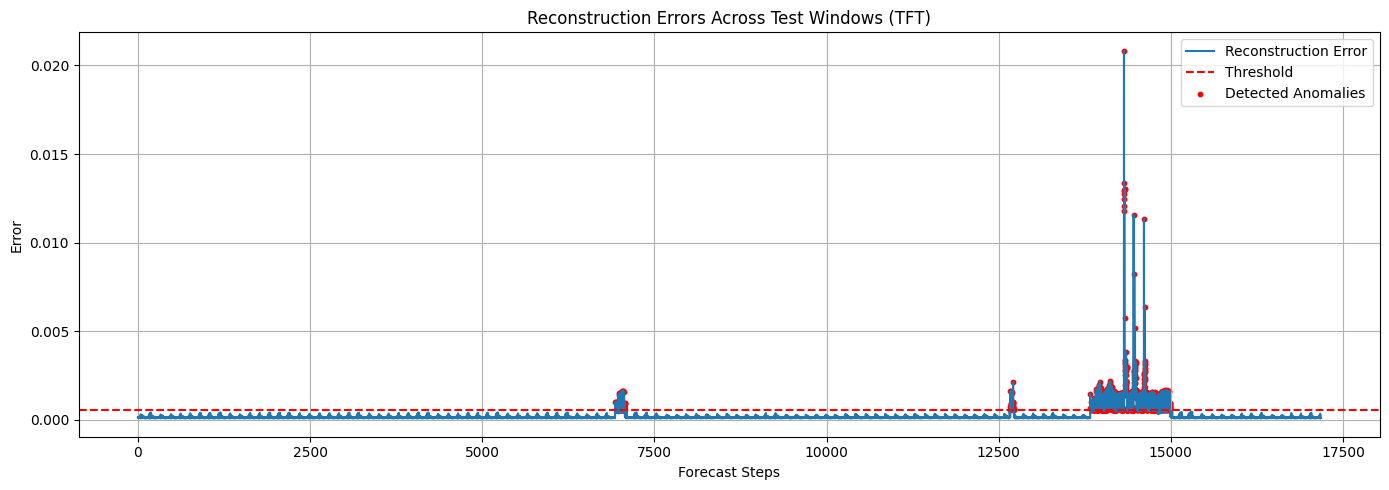

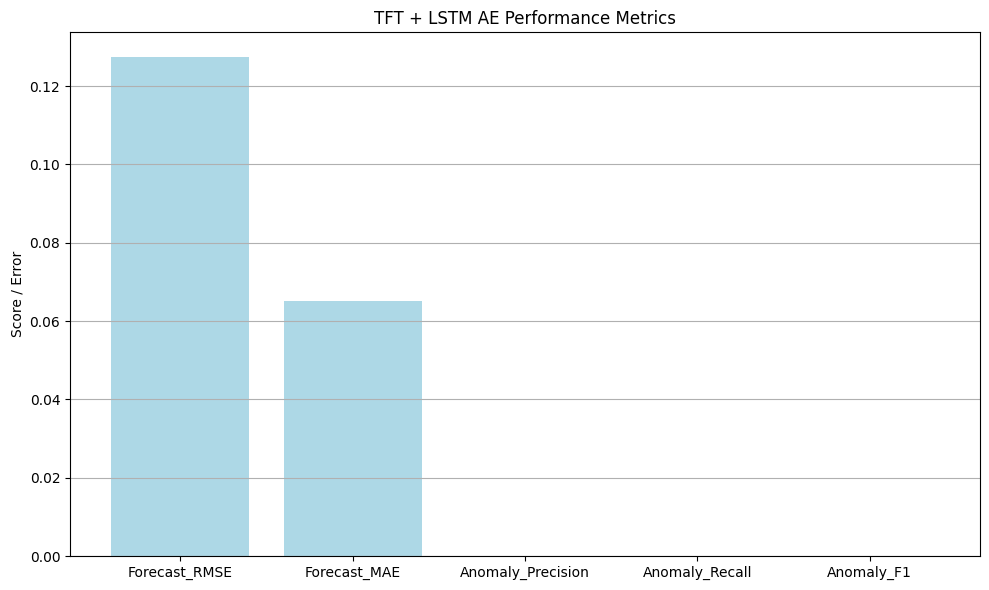

In [4]:
# ========================
# 10. EVALUATION
# ========================

# Forecasting metrics
y_pred_all = np.vstack(forecast_list)
y_true_all = np.vstack(true_windows)

forecast_rmse = np.sqrt(mean_squared_error(y_true_all.reshape(-1), y_pred_all.reshape(-1)))
forecast_mae = mean_absolute_error(y_true_all.reshape(-1), y_pred_all.reshape(-1))

print(f"\n📈 Forecasting Evaluation on Test:")
print(f"RMSE: {forecast_rmse:.5f}")
print(f"MAE:  {forecast_mae:.5f}")

# Anomaly detection metrics
all_true_labels = np.zeros_like(np.hstack(anomaly_flags_list))  # Assume all normal
all_detected = np.hstack(anomaly_flags_list)

precision = precision_score(all_true_labels, all_detected, zero_division=0)
recall = recall_score(all_true_labels, all_detected, zero_division=0)
f1 = f1_score(all_true_labels, all_detected, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# ========================
# 11. SAVE METRICS
# ========================

metrics_results = {
    "Model": "TFT + LSTM AE",
    "Forecast_RMSE": forecast_rmse,
    "Forecast_MAE": forecast_mae,
    "Anomaly_Precision": precision,
    "Anomaly_Recall": recall,
    "Anomaly_F1": f1
}

metrics_df = pd.DataFrame([metrics_results])
metrics_df.to_csv("metrics_tft_pipeline.csv", index=False)
print("\n✅ Metrics saved to 'metrics_tft_pipeline.csv'.")

# ========================
# 12. PLOTS
# ========================

# Plot Reconstruction Errors
plt.figure(figsize=(14,5))
all_errors = np.hstack(reconstruction_errors)
plt.plot(all_errors, label='Reconstruction Error')
plt.axhline(np.percentile(all_errors, THRESHOLD_PERCENTILE), color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)),
            all_errors[all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)],
            color='red', label='Detected Anomalies', s=10)
plt.title("Reconstruction Errors Across Test Windows (TFT)")
plt.xlabel("Forecast Steps")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_tft.png")
plt.show()

# Plot Metrics
metric_names = ["Forecast_RMSE", "Forecast_MAE", "Anomaly_Precision", "Anomaly_Recall", "Anomaly_F1"]
metric_values = [forecast_rmse, forecast_mae, precision, recall, f1]

plt.figure(figsize=(10,6))
plt.bar(metric_names, metric_values, color='lightblue')
plt.title("TFT + LSTM AE Performance Metrics")
plt.ylabel("Score / Error")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("metrics_bar_chart_tft.png")
plt.show()